# Note segmentation RNN training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import GRU, Bidirectional, Dropout, Input, TimeDistributed, BatchNormalization, Dense, Conv1D, Activation
from keras.models import Model
from keras.optimizers import Adam
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


## Loading data

In [2]:
data = pd.read_pickle("../../Data/Guitar/File_onset_data_final.pkl")

In [3]:
np.mean(data["x"].apply(lambda x: x.shape[0]))

50000.0

In [4]:
data["Riff"] = data["File"].str.split("riff").str[-1].str.split(".").str[0].str.split("_").str[0]

In [5]:
train_riffs = np.random.choice(data["Riff"].unique(), size=int(0.8*data["Riff"].unique().shape[0]), replace=False)

In [6]:
train_riffs

array(['23', '27', '29', '28', '15', '1', '12', '26', '3', '7', '2', '8',
       '22', '20', '13', '31', '19', '11', '16', '25', '30', '10', '18'],
      dtype=object)

In [7]:
train_data = data[data["Riff"].isin(train_riffs)].reset_index(drop=True)
val_data = data[~data["Riff"].isin(train_riffs)].reset_index(drop=True)
train_data.shape, val_data.shape

((197, 5), (41, 5))

Reshaping data

In [8]:
length = 50000

In [9]:
X_train = np.array([[[]]])
y_train = np.array([[[]]])
for i in range(train_data.shape[0]):
    x = train_data["x"].values[i].reshape((1, length, 1))
    X_train = np.append(X_train, x)
    y = train_data["y"].values[i].reshape((1, length//10, 1))
    y_train = np.append(y_train, y)
    
X_val = np.array([[[]]])
y_val = np.array([[[]]])
for i in range(val_data.shape[0]):
    x = val_data["x"].values[i].reshape((1, length, 1))
    X_val = np.append(X_val, x)
    y = val_data["y"].values[i].reshape((1, length//10, 1))
    y_val = np.append(y_val, y)

In [10]:
X_train = X_train.reshape(train_data.shape[0], length, 1)
X_val = X_val.reshape(val_data.shape[0], length, 1)
y_train = y_train.reshape(train_data.shape[0], length//10, 1)
y_val = y_val.reshape(val_data.shape[0], length//10, 1)

In [11]:
X_train.shape, y_train.shape

((197, 50000, 1), (197, 5000, 1))

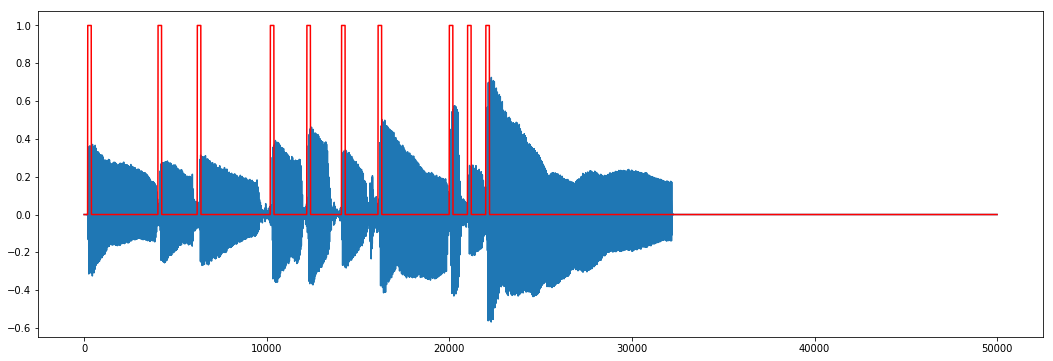

In [12]:
plt.figure(figsize=(18,6))
plt.plot(3*X_train[0])
plt.plot(np.arange(0, length, 10), y_train[0], "r")

## Model building

In [28]:
def build_model(input_shape):
    X_input = Input(shape=input_shape)
    X = Conv1D(196, kernel_size=10, strides=10)(X_input)
    X = BatchNormalization()(X)
    X = Activation("relu")(X)
    X = Bidirectional(GRU(units = 128, return_sequences = True))(X)
    X = BatchNormalization()(X)
    X_output = TimeDistributed(Dense(1, activation = "sigmoid"))(X)
    
    return Model(inputs=X_input, outputs=X_output)

In [29]:
model = build_model((length,1))

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 50000, 1)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5000, 196)         2156      
_________________________________________________________________
batch_normalization_5 (Batch (None, 5000, 196)         784       
_________________________________________________________________
activation_3 (Activation)    (None, 5000, 196)         0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 5000, 256)         249600    
_________________________________________________________________
batch_normalization_6 (Batch (None, 5000, 256)         1024      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 5000, 1)           257       
Total para

## Model training

In [32]:
import keras.backend as K
from keras.losses import binary_crossentropy

def sensitivity(y_pred, y_true):
    """
    param:
    y_pred - Predicted labels
    y_true - True labels 
    Returns:
    Specificity score
    """
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    pos_y_true = y_true
    pos_y_pred = y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    tp = K.sum(pos_y_true * pos_y_pred)
    fn = K.sum(pos_y_true * neg_y_pred)
    sensitivity = tp / (tp + fn + K.epsilon())
    return sensitivity

def precision(y_pred, y_true):
    neg_y_true = 1 - y_true
    neg_y_pred = 1 - y_pred
    pos_y_true = y_true
    pos_y_pred = y_pred
    fp = K.sum(neg_y_true * y_pred)
    tn = K.sum(neg_y_true * neg_y_pred)
    tp = K.sum(pos_y_true * pos_y_pred)
    fn = K.sum(pos_y_true * neg_y_pred)
    precision = tp / (tp + fp + K.epsilon())
    return precision

def sensitivity_loss(y_pred, y_true):
    return 1 - sensitivity(y_pred, y_true)

def precision_loss(y_pred, y_true):
    return 1 - precision(y_pred, y_true)

def precision_sensitivity_loss(y_pred, y_true):
    return sensitivity_loss(y_pred, y_true) + 0.1 * precision_loss(y_pred, y_true)

def bce_sensitivity(y_pred, y_true):
    return sensitivity_loss(y_pred, y_true) + binary_crossentropy(y_pred, y_true)

In [33]:
model.compile(Adam(), loss=precision_sensitivity_loss, metrics=["accuracy", sensitivity, precision])

In [34]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('Checkpoints/seg_gru_{val_sensitivity:.2f}.hdf5', verbose=1, monitor='val_sensitivity',
                             save_best_only=True, mode='max')

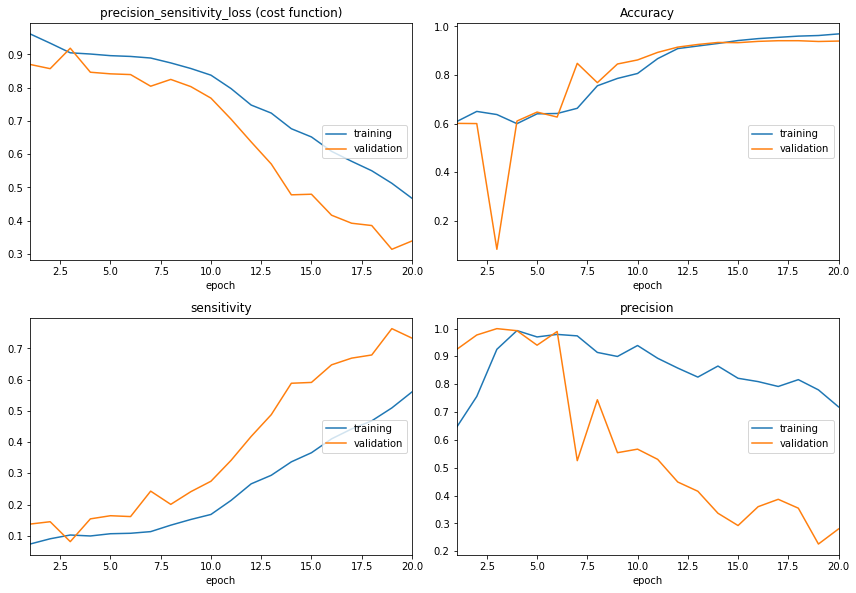

precision_sensitivity_loss (cost function):
training   (min:    0.467, max:    0.962, cur:    0.467)
validation (min:    0.314, max:    0.919, cur:    0.339)

Accuracy:
training   (min:    0.599, max:    0.969, cur:    0.969)
validation (min:    0.081, max:    0.941, cur:    0.940)

sensitivity:
training   (min:    0.074, max:    0.561, cur:    0.561)
validation (min:    0.081, max:    0.763, cur:    0.733)

precision:
training   (min:    0.646, max:    0.993, cur:    0.719)
validation (min:    0.226, max:    1.000, cur:    0.280)

Epoch 00020: val_sensitivity did not improve from 0.76347


In [35]:
model.fit(X_train, y_train, batch_size=32, epochs=20, 
          validation_data=(X_val, y_val), callbacks=[PlotLossesKeras(), checkpoint])

## Model evaluation

In [121]:
model.load_weights("Checkpoints/final_weights/seg_gru_v3_0.96.hdf5")

In [ ]:
pred = model.predict(X_val)

In [141]:
pred.shape

(34, 5000, 1)

In [142]:
y_pred = (pred >= 0.5).astype(int)

In [143]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val.reshape(y_val.shape[0]*y_val.shape[1]), y_pred.reshape(y_pred.shape[0]*y_pred.shape[1]))

In [144]:
cm_norm = np.vstack((cm[0,:]/cm[0,:].sum(), cm[1,:]/cm[1,:].sum()))

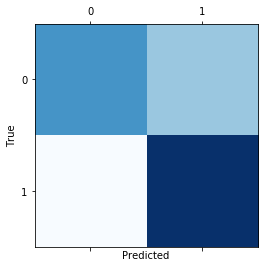

array([[0.61618006, 0.38381994],
       [0.00318471, 0.99681529]])

In [145]:
plt.matshow(cm_norm, cmap=plt.cm.Blues)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
cm_norm

In [146]:
from sklearn.metrics import classification_report
print(classification_report(y_val.reshape(y_val.shape[0]*y_val.shape[1]), y_pred.reshape(y_pred.shape[0]*y_pred.shape[1])))

              precision    recall  f1-score   support

         0.0       1.00      0.62      0.76    163720
         1.0       0.09      1.00      0.17      6280

   micro avg       0.63      0.63      0.63    170000
   macro avg       0.55      0.81      0.46    170000
weighted avg       0.97      0.63      0.74    170000



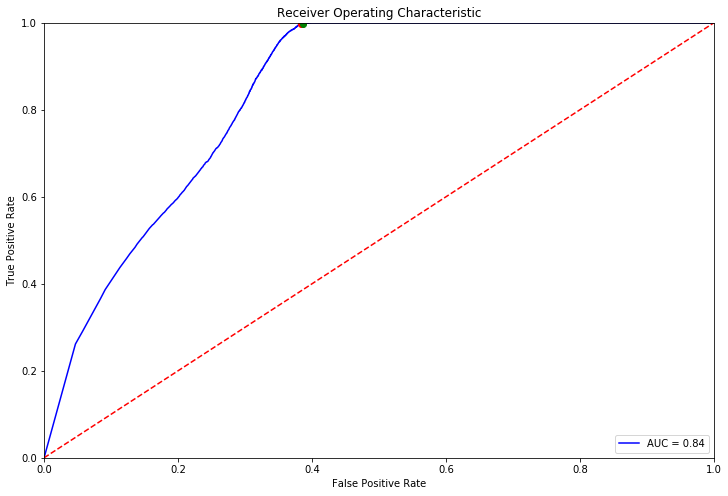

In [147]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, threshold = roc_curve(y_val.reshape(y_val.shape[0]*y_val.shape[1]), pred.reshape(pred.shape[0]*pred.shape[1]))
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

thresh_0_5 = np.argmin(np.abs(threshold - 0.5))
plt.plot(fpr[thresh_0_5], tpr[thresh_0_5], "ro")
thresh_0_4 = np.argmin(np.abs(threshold - 0.4))
plt.plot(fpr[thresh_0_4], tpr[thresh_0_4], "go")
plt.show()

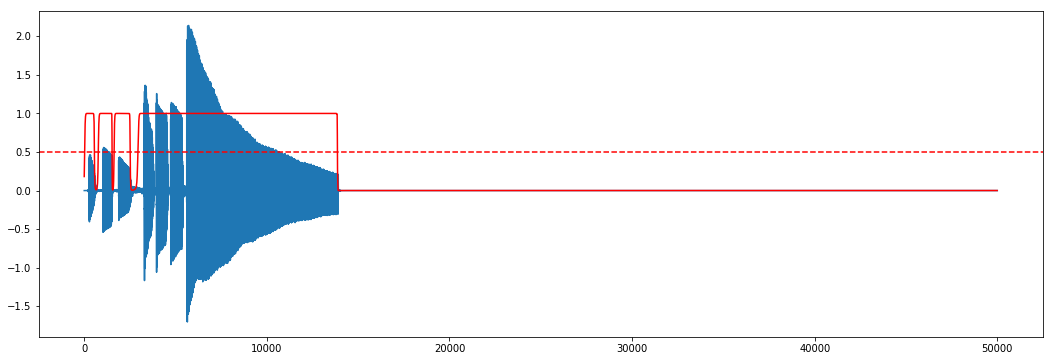

In [152]:
index = np.random.randint(0, X_val.shape[0])
plt.figure(figsize=(18,6))
plt.plot(3*X_val[index])
plt.plot(np.arange(0, length, 10), pred[index], "r")
plt.axhline(0.5, color="r", linestyle="--")